<a href="https://colab.research.google.com/github/saptakdutta/Sentiment-analysis/blob/master/Copy_of_Comparison_of_sentiment_analysis_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Easier way to install on PC?](https://towardsdatascience.com/tensorflow-gpu-installation-made-easy-use-conda-instead-of-pip-52e5249374bc)

##Check to see that the tensorflow can access the GPU

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


##Import all the general libraries

In [0]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

##Enter in the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!ls "/content/drive/My Drive/Machine Learning"
!cp "/content/drive/My Drive/Machine Learning/SLFC survey.xlsx" "SLFC survey.xlsx"
!ls

 Comparison_of_sentiment_analysis_methods.ipynb   Seattle_Hotels.csv
 RNN_Sent_0_1.h5				 'SLFC survey.xlsx'
 drive	 sample_data  'SLFC survey.xlsx'


In [5]:
import io

df = pd.read_excel('SLFC survey.xlsx')

df = df[['Temperature', 'Sentiment']]
df = df.replace('B1 Basement', 'B')
print(df.head(10))
print(df['Temperature'].apply(lambda x: len(x.split(' '))).sum())

                                         Temperature Sentiment
0  A proper BAS system that can actually determin...  Negative
1  I think probably that it's not adjusted to the...   Neutral
2   The heat is not high enough so put on more heat.  Negative
3  I completed this survey last year and also com...  Negative
4  I'm thinking it's just the seasons changing.  ...  Negative
5         There is a bit of a draft from the window.  Negative
6  They should turn on the cooling system on Sund...  Negative
7  I sit right under a vent and Mondays are alway...  Negative
8                                         It's okay.   Neutral
9  I don't think there is really much to do.  Whe...   Neutral
5828


# Sentiment Analysis

##Look at the distribution of the classes

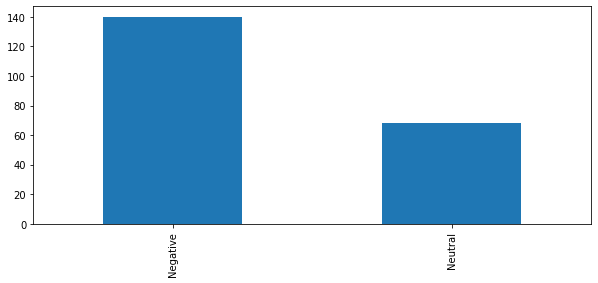

In [6]:
my_tags = ['Negative', 'Neutral']
plt.figure(figsize=(10,4))
df.Sentiment.value_counts().plot(kind='bar');

In [0]:
def print_plot(index):
    example = df[df.index == index][['Temperature', 'Sentiment']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])

In [8]:
print_plot(0)
print_plot(1)

A proper BAS system that can actually determine the air temperature outside and be more reactive so that when it's -5 outside in May the air conditioning doesn't come on.  Also personal temperature, I should be allowed to have a personal heater at my desk if I'm freezing.
Tag: Negative
I think probably that it's not adjusted to the changes in temperatures with the season so it takes awhile to readjust.  I'm not sure how to solve that except maybe trying to keep one constant temperature.  Is it doable?
Tag: Neutral


## Clean up the text

In [10]:
nltk.download('stopwords')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
from nltk.stem import PorterStemmer 

ps = PorterStemmer() 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    text = ps.stem(text)
    return text
    
df['Temperature'] = df['Temperature'].apply(clean_text)
df['Temperature'].apply(lambda x: len(x.split(' '))).sum()

2488

In [15]:
print_plot(0)

proper bas system actually determine air temperature outside reactive 5 outside may air conditioning doesnt come also personal temperature allowed personal heater desk im freez
Tag: Negative


In [19]:
df[0:5]

,Temperature,Sentiment
0,proper bas system actually determine air tempe...,Negative
1,think probably adjusted changes temperatures s...,Neutral
2,heat high enough put heat,Negative
3,completed survey last year also complained tem...,Negative
4,im thinking seasons changing cold cold hot hot...,Negative


In [0]:
list(df.columns)

['Temperature', 'Sentiment']

## Define the confusion matrix function

In [0]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

## Lexicon Based Sentiment Analysis

### Textblob

In [0]:
from textblob import TextBlob, Word
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.classifiers import NaiveBayesClassifier

#### Run the textblob lexicon model

In [0]:
#%%Sentiment Analysis for Temperature (polarity, subjectivity) .sentiment[0] means we are only looking at polarity
survey_resp_temp = df
survey_resp_temp['Textblob'] = survey_resp_temp['Temperature'].apply(lambda x: TextBlob(x).sentiment[0] )
survey_resp_temp[['Temperature','Sentiment', 'Textblob']].head()

,Temperature,Sentiment,Textblob
0,proper bas system actually determine air tempe...,Negative,0.000000
1,think probably adjusted changes temperatures s...,Neutral,0.250000
2,heat high enough put heat,Negative,0.080000
3,completed survey last year also complained tem...,Negative,-0.042857
4,im thinking seasons changing cold cold hot hot...,Negative,-0.200000


#### Build a histogram of distributions to show accuracy

In [0]:
hist = survey_resp_temp
hist[0:5]

,Temperature,Sentiment,Textblob
0,proper bas system actually determine air tempe...,Negative,0.000000
1,think probably adjusted changes temperatures s...,Neutral,0.250000
2,heat high enough put heat,Negative,0.080000
3,completed survey last year also complained tem...,Negative,-0.042857
4,im thinking seasons changing cold cold hot hot...,Negative,-0.200000


In [0]:
hist.Sentiment = hist.Sentiment.map(dict(Negative=-1, Neutral=0))
hist = hist[['Temperature', 'Sentiment', 'Textblob']]
hist[0:5]

,Temperature,Sentiment,Textblob
0,proper bas system actually determine air tempe...,-1,0.000000
1,think probably adjusted changes temperatures s...,0,0.250000
2,heat high enough put heat,-1,0.080000
3,completed survey last year also complained tem...,-1,-0.042857
4,im thinking seasons changing cold cold hot hot...,-1,-0.200000


Text(0, 0.5, 'Frequency')

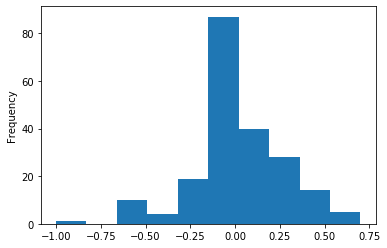

In [0]:
plt.hist(hist['Textblob'], bins=10)
plt.ylabel('Frequency')

(-1, 1)

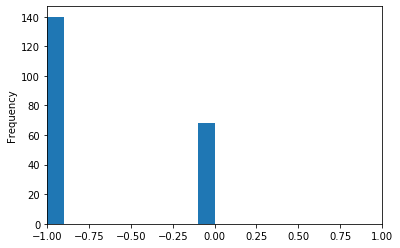

In [0]:
plt.hist(hist['Sentiment'], bins=10)
plt.ylabel('Frequency')
plt.xlim(left=-1, right = 1)

Take a look at the sentiment score of the classified negatves

(-1, 1)

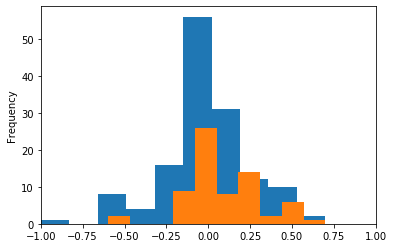

In [0]:
plt.hist(hist.Textblob[hist.Sentiment == -1], bins = 10)
plt.hist(hist.Textblob[hist.Sentiment == 0], bins = 10)
plt.ylabel('Frequency')
plt.xlim(left=-1, right = 1)

In [0]:
hist[hist.Sentiment == -1][0:20]
print(hist.Temperature[15])

air conditioning notice mostly summer


#### Test Accuracy

In [0]:
survey_resp_temp[0:5]

,Temperature,Sentiment,Textblob
0,proper bas system actually determine air tempe...,-1,0.000000
1,think probably adjusted changes temperatures s...,0,0.250000
2,heat high enough put heat,-1,0.080000
3,completed survey last year also complained tem...,-1,-0.042857
4,im thinking seasons changing cold cold hot hot...,-1,-0.200000


In [0]:
survey_resp_temp['Tb'] = 1
survey_resp_temp.fillna
survey_resp_temp['Tb'][survey_resp_temp['Textblob'] < 0] = -1
survey_resp_temp['Tb'][survey_resp_temp['Textblob'] == 0] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
survey_resp_temp = survey_resp_temp.drop('Textblob', axis = 1)
survey_resp_temp[0:5]

,Temperature,Sentiment,Tb
0,proper bas system actually determine air tempe...,-1,0
1,think probably adjusted changes temperatures s...,0,1
2,heat high enough put heat,-1,1
3,completed survey last year also complained tem...,-1,-1
4,im thinking seasons changing cold cold hot hot...,-1,-1


In [0]:
y_pred = survey_resp_temp['Tb']
y_test = survey_resp_temp['Sentiment']
print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.33653846153846156


Not good at all

#### Confusion matrix

In [0]:
y_actu = pd.Series(y_test, name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)

In [0]:
df_confusion

Predicted,-1,0,1
Actual,,,
-1,46,38,56
0,12,24,32


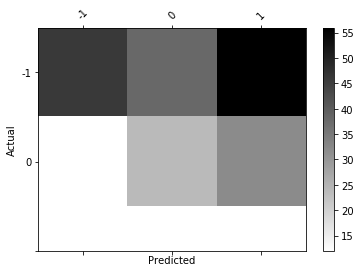

In [0]:
plot_confusion_matrix(df_confusion)

### Vader

In [0]:
pip install vaderSentiment

     |████████████████████████████████| 133kB 8.9MB/s 


In [0]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#### Run the model

In [0]:
survey_resp_temp2 = df
analyzer = SentimentIntensityAnalyzer()
scores = []

for i in range(0,len(survey_resp_temp2['Temperature'])):
    score = analyzer.polarity_scores(survey_resp_temp2['Temperature'][i])
    scores.append(score)
    
df_scores= pd.DataFrame(scores)  

#check the number of negative, neutral and positive
len(df_scores[df_scores['compound'] > 0])
len(df_scores[df_scores['compound'] == 0])
len(df_scores[df_scores['compound'] < 0])

df_scores['compound'][0:5]
df['Vader'] = df_scores['compound']
df[0:5]

,Temperature,Sentiment,Textblob,Tb,Vader
0,proper bas system actually determine air tempe...,-1,0.000000,0,-0.1027
1,think probably adjusted changes temperatures s...,0,0.250000,1,0.4767
2,heat high enough put heat,-1,0.080000,1,0.0000
3,completed survey last year also complained tem...,-1,-0.042857,-1,-0.5903
4,im thinking seasons changing cold cold hot hot...,-1,-0.200000,-1,-0.4767


In [0]:
df['Vd'] = 'Neutral'
df.fillna
df['Vd'][df['Vader'] < 0] = 'Negative'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
df[0:5]

,Temperature,Sentiment,Textblob,Tb,Vader,Vd
0,proper bas system actually determine air tempe...,-1,0.000000,0,-0.1027,Negative
1,think probably adjusted changes temperatures s...,0,0.250000,1,0.4767,Neutral
2,heat high enough put heat,-1,0.080000,1,0.0000,Neutral
3,completed survey last year also complained tem...,-1,-0.042857,-1,-0.5903,Negative
4,im thinking seasons changing cold cold hot hot...,-1,-0.200000,-1,-0.4767,Negative


#### Histogram

(-1, 1)

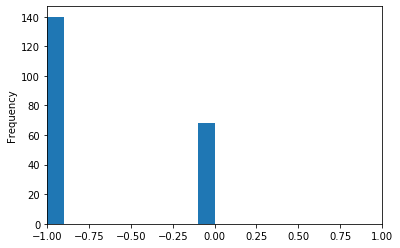

In [0]:
plt.hist(hist['Sentiment'], bins=10)
plt.ylabel('Frequency')
plt.xlim(left=-1, right = 1)

(-1, 1)

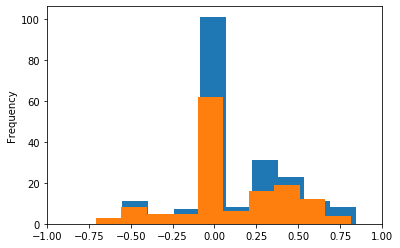

In [0]:
plt.hist(df['Vader'], bins=10)
plt.hist(df['Vader'].loc[df['Sentiment']== -1], bins=10)
plt.ylabel('Frequency')
plt.xlim(left=-1, right = 1)

In [0]:
df['Vader'].loc[df['Sentiment']== 0]

1      0.4767
8      0.2263
9     -0.3353
12     0.0000
13     0.2263
        ...  
193    0.7003
196    0.3536
205    0.0000
206    0.0000
207    0.6133
Name: Vader, Length: 68, dtype: float64

#### Test Accuracy

In [0]:
y_pred = df['Vd']
y_test = df['Sentiment']
print('accuracy %s' % accuracy_score(y_pred, y_test))

TypeError: ignored

Even worse unfortunately

#### Confusion matrix

In [0]:
y_actu = pd.Series(y_test, name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)

In [0]:
df_confusion

Predicted,Negative,Neutral
Actual,,
-1,22,118
0,7,61


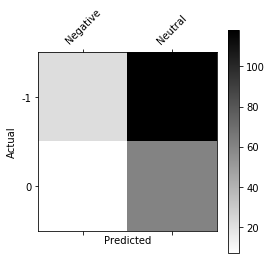

In [0]:
plot_confusion_matrix(df_confusion)

## Binomial Sentiment Classification (Neg/Neutral)

### Randomly split up the data into test (30%) and training (70%) sets

try 50-50 or 30-70

In [0]:
X = df.Temperature
y = df.Sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)

### Naive Bayes

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

#### Create the classifier pipeline

In [0]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

#### Predict the test variables

In [0]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

CPU times: user 4.24 ms, sys: 0 ns, total: 4.24 ms
Wall time: 4.53 ms


#### Verify the accuracy of the results

In [0]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.6984126984126984
              precision    recall  f1-score   support

    Negative       0.70      0.95      0.81        42
     Neutral       0.67      0.19      0.30        21

    accuracy                           0.70        63
   macro avg       0.68      0.57      0.55        63
weighted avg       0.69      0.70      0.64        63



#### Confusion matrix visualizing error distribution

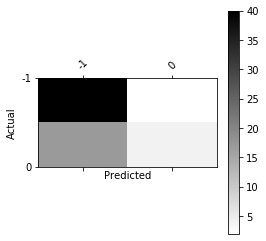

In [0]:
y_actu = pd.Series(np.array(y_test, dtype = '<U8'), name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred, dropna = False)
plot_confusion_matrix(df_confusion)

In [0]:
df_confusion

Predicted,-1,0
Actual,,
-1,40,2
0,17,4


### Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression


#### Create the classifier pipeline

In [0]:
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5, solver = 'lbfgs')),
               ])
logreg.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=100000.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

#### Predict the test variables

In [0]:
%%time

y_pred = logreg.predict(X_test)

CPU times: user 4.2 ms, sys: 11 µs, total: 4.22 ms
Wall time: 5.53 ms


#### Verify the accuracy of the results

In [0]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.7936507936507936
              precision    recall  f1-score   support

    Negative       0.81      0.90      0.85        42
     Neutral       0.75      0.57      0.65        21

    accuracy                           0.79        63
   macro avg       0.78      0.74      0.75        63
weighted avg       0.79      0.79      0.79        63



#### Confusion matrix visualizing error distribution

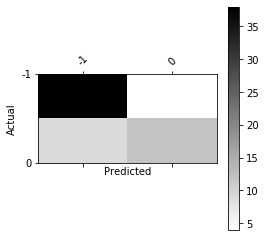

In [0]:
y_actu = pd.Series(np.array(y_test, dtype = '<U8'), name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred, dropna = False)
plot_confusion_matrix(df_confusion)

In [0]:
df_confusion

Predicted,-1,0
Actual,,
-1,38,4
0,9,12


### Support Vector Machine (SVM)

In [0]:
from sklearn.linear_model import SGDClassifier


#### Create the classifier pipeline

In [0]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

#### Predict the test variables

In [0]:
%%time

y_pred = sgd.predict(X_test)

CPU times: user 4.04 ms, sys: 1.02 ms, total: 5.06 ms
Wall time: 7.27 ms


#### Verify the accuracy of the results

In [0]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.7301587301587301
              precision    recall  f1-score   support

    Negative       0.78      0.83      0.80        42
     Neutral       0.61      0.52      0.56        21

    accuracy                           0.73        63
   macro avg       0.69      0.68      0.68        63
weighted avg       0.72      0.73      0.72        63



#### Confusion matrix visualizing error distribution

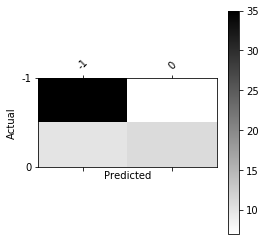

In [0]:
y_actu = pd.Series(np.array(y_test, dtype = '<U8'), name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred, dropna = False)
plot_confusion_matrix(df_confusion)

In [0]:
df_confusion

Predicted,-1,0
Actual,,
-1,35,7
0,10,11


### Decision tree classifier

In [0]:
from sklearn import tree

#### Create the pipeline

In [0]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', tree.DecisionTreeClassifier(random_state = 0, max_depth=2)),
               ])
sgd.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=2, max_features=None,
                               

#### Predict the test variables

In [0]:
%%time

y_pred = sgd.predict(X_test)

CPU times: user 4.32 ms, sys: 74 µs, total: 4.4 ms
Wall time: 4.12 ms


#### Verify result acuracy

In [0]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.7619047619047619
              precision    recall  f1-score   support

    Negative       0.76      0.93      0.84        42
     Neutral       0.75      0.43      0.55        21

    accuracy                           0.76        63
   macro avg       0.76      0.68      0.69        63
weighted avg       0.76      0.76      0.74        63



#### Confusion matrix

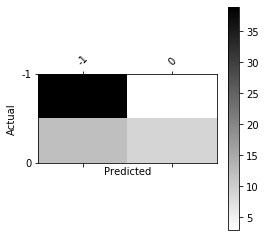

In [0]:
y_actu = pd.Series(np.array(y_test, dtype = '<U8'), name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred, dropna = False)
plot_confusion_matrix(df_confusion)

In [0]:
df_confusion

Predicted,-1,0
Actual,,
-1,39,3
0,12,9


### Random forest classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier

#### Create the classifier pipeline

In [0]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=10000, max_depth=30, random_state=0, min_samples_leaf=1)),
               ])
sgd.fit(X_train, y_train)

#### Predict the test variables

In [0]:
%%time

y_pred = sgd.predict(X_test)

CPU times: user 1.19 s, sys: 3.44 ms, total: 1.19 s
Wall time: 1.2 s


#### Verify the accuracy of the results

In [0]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.7936507936507936
              precision    recall  f1-score   support

    Negative       0.78      0.95      0.86        42
     Neutral       0.83      0.48      0.61        21

    accuracy                           0.79        63
   macro avg       0.81      0.71      0.73        63
weighted avg       0.80      0.79      0.78        63



#### Confusion matrix visualizing error distribution

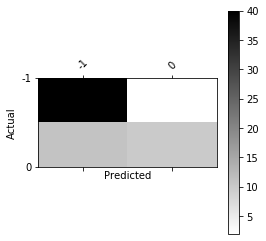

In [0]:
y_actu = pd.Series(np.array(y_test, dtype = '<U8'), name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred, dropna = False)
plot_confusion_matrix(df_confusion)

In [0]:
df_confusion

Predicted,-1,0
Actual,,
-1,40,2
0,11,10


In [0]:
sgd.n_outputs

AttributeError: ignored

### [Document Embedding with Paragraph Vectors (Doc2Vec)](https://github.com/susanli2016/NLP-with-Python/blob/master/Doc2Vec%20Consumer%20Complaint.ipynb)

In [0]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

In [0]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled
X_train, X_test, y_train, y_test = train_test_split(df.Temperature, df.Sentiment, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [0]:
all_data[:2]

[TaggedDocument(words=['summertime', 'make', 'cold', 'wintertime', 'dont', 'make', 'hot', 'always', 'cold'], tags=['Train_0']),
 TaggedDocument(words=['needs', 'better', 'air', 'flow', 'needs', 'air', 'exchanger', 'blow', 'stale', 'air'], tags=['Train_1'])]

In [0]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=10)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha
;

100%|██████████| 208/208 [00:00<00:00, 74610.04it/s]


''

In [0]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [0]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [0]:
logreg = LogisticRegression(n_jobs=1, C=1e5, solver = 'lbfgs')
logreg.fit(train_vectors_dbow, y_train)
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.6507936507936508
              precision    recall  f1-score   support

    Negative       0.81      0.62      0.70        42
     Neutral       0.48      0.71      0.58        21

    accuracy                           0.65        63
   macro avg       0.65      0.67      0.64        63
weighted avg       0.70      0.65      0.66        63



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


#### Confusion matrix

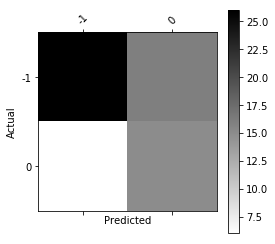

In [0]:
y_actu = pd.Series(np.array(y_test, dtype = '<U8'), name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred, dropna = False)
plot_confusion_matrix(df_confusion)

In [0]:
df_confusion

Predicted,-1,0
Actual,,
-1,26,16
0,6,15


### Bag of Words using Tensorflow

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [0]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils
use_gpu = True

Using TensorFlow backend.


In [0]:
train_size = int(len(df) * .7)
train_posts = df['Temperature'][:train_size]
train_tags = df['Sentiment'][:train_size]

test_posts = df['Temperature'][train_size:]
test_tags = df['Sentiment'][train_size:]

In [0]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

In [0]:
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [0]:
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [0]:
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [0]:
batch_size = 24
epochs = 50

#### Build the model

In [0]:
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Test the sensitivity of the input layers. No free lunch- no one algorithm is the best.

How are neural nets trimmed. How many nodes and layers are appropriate in text analysis Plot with # of layers vs percent accuracy 5 samples to start with

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 130 samples, validate on 15 samples
Epoch 1/50
130/130 [==============================] - 1s 4ms/step - loss: 0.6796 - acc: 0.5846 - val_loss: 0.5820 - val_acc: 0.8667
Epoch 2/50
130/130 [==============================] - 0s 349us/step - loss: 0.5665 - acc: 0.6923 - val_loss: 0.4901 - val_acc: 0.7333
Epoch 3/50
130/130 [==============================] - 0s 313us/step - loss: 0.4727 - acc: 0.7000 - val_loss: 0.4385 - val_acc: 0.7333
Epoch 4/50
130/130 [==============================] - 0s 290us/step - loss: 0.4136 - acc: 0.7769 - val_loss: 0.4085 - val_acc: 0.8000
Epoch 5/50
130/130 [==============================] - 0s 343us/step - loss: 0.3506 - acc: 0.8615 - val_loss: 0.3812 - val_acc: 0.8000
Epoch 6/50
130/130 [==============================] - 0s 303us/step - loss: 0.3038 - acc: 0.9154 - val_loss: 0.3615 - val_acc: 0.9333
Epoch 7/50
130/130 [==============================] - 0s 278us/step - loss: 0.2590 - acc: 0.9615 - val_loss: 0.3411 - val_acc: 1.0000
Epoch 8/50
130/130 

#### validate the accuracy 

In [0]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
score

63/63 [==============================] - 0s 136us/step


[0.41508504038765315, 0.8412698393776303]

In [0]:
model.evaluate(x_test, y_test)

63/63 [==============================] - 0s 202us/step


[0.43400152240480694, 0.8571428457895914]

In [0]:
pd.concat([x_test, y_test], axis = 1)

TypeError: ignored

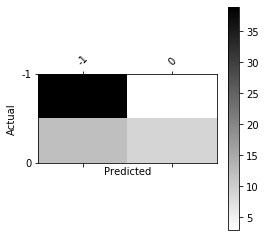

In [0]:
df_confusion = pd.crosstab(y_actu, y_pred, dropna = False)
plot_confusion_matrix(df_confusion)

In [0]:
df_confusion

Predicted,-1,0
Actual,,
-1,39,3
0,12,9


In [0]:
con_mat = tf.math.confusion_matrix(labels=y_actu, predictions=y_pred).numpy()

In [0]:
from keras import metrics

In [0]:
print(confusion_matrix(x_test, y_pred))

# Sankey Diagrams

# Association Node Networks using ARM

Python doesn't have the arulesviz library which makes it impossible to draw the Node Networks. But we can call R from within python here

In [0]:
%load_ext rpy2.ipython

In [0]:
import rpy2.robjects.packages as rpackages
utils = rpackages.importr('utils')

utils.chooseCRANmirror(ind=1) # select the first mirror in the list
utils.chooseBioCmirror(ind=1)

packnames = ('tm', 'SnowballC', 'arules', 'devtools')
from rpy2.robjects.vectors import StrVector
utils.install_packages(StrVector(packnames))

In [0]:
%%R

install.packages("arulesViz", lib="/data/Rpackages/")

In [0]:
%%R
library(tidyverse)
library(readxl)
library(tm)
library(SnowballC) 
library(arules)
library(arulesViz)

In [0]:
%%R
txt = read_excel('SLFC survey.xlsx')
txt

# A tibble: 208 x 4
   `Floor Work On` `Workspace Locati… Temperature                      Sentiment
   <chr>           <chr>              <chr>                            <chr>    
 1 3               99 Bank St.        A proper BAS system that can ac… Negative 
 2 4               50 O'Connor        I think probably that it's not … Neutral  
 3 7               99 Bank St.        The heat is not high enough so … Negative 
 4 13              50 O'Connor        I completed this survey last ye… Negative 
 5 3               99 Bank St.        I'm thinking it's just the seas… Negative 
 6 9               50 O'Connor        There is a bit of a draft from … Negative 
 7 16              50 O'Connor        They should turn on the cooling… Negative 
 8 5               99 Bank St.        I sit right under a vent and Mo… Negative 
 9 5               50 O'Connor        It's okay.                       Neutral  
10 17              50 O'Connor        I don't think there is really m… Neutral  
# … with

In [0]:
%%R
txt$`Temperature`[1:5]

[1] "A proper BAS system that can actually determine the air temperature outside and be more reactive so that when it's -5 outside in May the air conditioning doesn't come on.  Also personal temperature, I should be allowed to have a personal heater at my desk if I'm freezing."                                                                                                                                                                                                                    
[2] "I think probably that it's not adjusted to the changes in temperatures with the season so it takes awhile to readjust.  I'm not sure how to solve that except maybe trying to keep one constant temperature.  Is it doable?"                                                                                                                                                                                                                                                                         
[3] "The heat is n

### Preprocessing text

In [0]:
%%R
#-------------------------------------------------DETAILED TEXT MINING --------------------------------------------
## Preprocessing to create a document term matrix
mydata <- txt$`Temperature`
documents <- VectorSource(t(mydata))
jeopCorpus <- Corpus(documents)
jeopCorpus <- tm_map(jeopCorpus, PlainTextDocument)
jeopCorpus <- tm_map(jeopCorpus, content_transformer(tolower))
jeopCorpus <- tm_map(jeopCorpus, removePunctuation)
jeopCorpus <- tm_map(jeopCorpus, stripWhitespace)
jeopCorpus <- tm_map(jeopCorpus, removeNumbers)
jeopCorpus <- tm_map(jeopCorpus, removeWords, stopwords("english"))
jeopCorpus <- tm_map(jeopCorpus, stemDocument)
# jeopCorpus <- tm_map(jeopCorpus, removeWords, c("per","awocwo","tke","acceptgn","cwomd","jeansd","mwr","lwr","ghazi",
#                                                 "barryrw","barrygn","robert","wbarri","extend","reason","work","jean",
#                                                 "thank","awomd","order","barri","teeven","cli","close","accept","fulli",
#                                                 "mbeaudri","mike","allison","aschmidtk","schmidtk","verbal","can","now",
#                                                 "pleas","will","made","alt","need","new","open","due","use","complet",
#                                                 "done","went","flr", "technician", "comment", "jpl", "awo", "cwo", "gill",
#                                                 "sab","ben","message","left", "rene", "lattfield", "tstatsk"))
# jeopCorpus <- tm_map(jeopCorpus, content_transformer(gsub), pattern = "\\b(stat|tstat|statsk|tstatsk|statssk)\\b", 
#                                                                       replacement = "tstat")

### Turn into a tocument term matrix

In [0]:
%%R
df_experiment <- data.frame(text = get("content", jeopCorpus))
head(df_experiment)

dtm <- DocumentTermMatrix(jeopCorpus)

#-----------Create a bar plot of the most common terms ----------------------------
#create a term document matrix instead of document term matrix
tdm <- TermDocumentMatrix(jeopCorpus)
m <- as.matrix(tdm)
v <- sort(rowSums(m),decreasing=TRUE)
d <- data.frame(word = names(v),freq=v)

# Write the raw document text matrix to a CSV ----
write.csv(as.matrix(dtm), file="dtm.csv")

#Word frequency matrix
freq <- colSums(as.matrix(dtm))
length(freq)
ord <- order(freq)
m <- as.matrix(freq)
dim(m)

#creating term matrix with TF-IDF weighting
terms <-DocumentTermMatrix(jeopCorpus,control = list(weighting = function(x) weightTfIdf(x, normalize = FALSE)))
write.csv(as.matrix(terms), file="tfidf.csv")

#Word frequency matrix after TF-IDF weighting
freq <- colSums(as.matrix(dtm))
length(freq)
ord <- order(freq)
m <- as.matrix(freq)
dim(m)

dtmss <- removeSparseTerms(dtm, 0.994) # This makes a matrix that is only 15% empty space, maximum.  0.9999 usual 0.98
write.csv(as.matrix(dtmss), file="dtmss.csv")

## ---- Using non-sparse dtm conduct an association rule analysis

mydata <- read.csv('dtmss.csv', stringsAsFactors = FALSE)
mydata[1] <- NULL

### Set up the support and confidence parameters

In [0]:
%%R
# Set support and confidence values
Support_ARM = 0.01
Confidence_ARM = 0.85
Number_of_rules = 20

## Support 0.005 and confidence 0.80 support sort
mydata <- sapply(mydata,as.logical)
rules <- apriori(mydata,parameter = list(sup = Support_ARM, conf = Confidence_ARM,target="rules"))
summary(rules)
rules.sorted <- sort(rules, by="support")

subrules <- head(sort(rules, by="support"),Number_of_rules)
view(subrules) 
write(subrules, file = "dataNoClusteringSup00005Conf_support.csv", sep = ",")

set.seed(1)

### plot the graphs

Available control parameters (with default values):
main	 =  Graph for 20 rules
nodeColors	 =  c("#66CC6680", "#9999CC80")
nodeCol	 =  c("#EE0000FF", "#EE0303FF", "#EE0606FF", "#EE0909FF", "#EE0C0CFF", "#EE0F0FFF", "#EE1212FF", "#EE1515FF", "#EE1818FF", "#EE1B1BFF", "#EE1E1EFF", "#EE2222FF", "#EE2525FF", "#EE2828FF", "#EE2B2BFF", "#EE2E2EFF", "#EE3131FF", "#EE3434FF", "#EE3737FF", "#EE3A3AFF", "#EE3D3DFF", "#EE4040FF", "#EE4444FF", "#EE4747FF", "#EE4A4AFF", "#EE4D4DFF", "#EE5050FF", "#EE5353FF", "#EE5656FF", "#EE5959FF", "#EE5C5CFF", "#EE5F5FFF", "#EE6262FF", "#EE6666FF", "#EE6969FF", "#EE6C6CFF", "#EE6F6FFF", "#EE7272FF", "#EE7575FF",  "#EE7878FF", "#EE7B7BFF", "#EE7E7EFF", "#EE8181FF", "#EE8484FF", "#EE8888FF", "#EE8B8BFF", "#EE8E8EFF", "#EE9191FF", "#EE9494FF", "#EE9797FF", "#EE9999FF", "#EE9B9BFF", "#EE9D9DFF", "#EE9F9FFF", "#EEA0A0FF", "#EEA2A2FF", "#EEA4A4FF", "#EEA5A5FF", "#EEA7A7FF", "#EEA9A9FF", "#EEABABFF", "#EEACACFF", "#EEAEAEFF", "#EEB0B0FF", "#EEB1B1FF", "#EEB3B3FF", "#EE

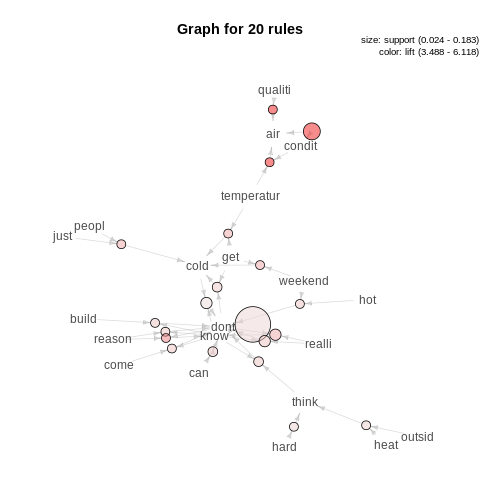

In [0]:
%%R
plot(subrules, method="graph", control=list(type="items"))

In [0]:
%%R
## Support 0.005 and confidence 0.80 lift sort
mydata <- sapply(mydata,as.logical)
rules <- apriori(mydata,parameter = list(sup = Support_ARM, conf = Confidence_ARM,target="rules"))
summary(rules)
rules.sorted <- sort(rules, by="lift")
 
subrules <- head(sort(rules, by="lift"),Number_of_rules)
view(subrules)
write(subrules, file = "dataNoClusteringSup00005Conf_lift.csv", sep = ",")

set.seed(1)


Error in as(data, "transactions") : 
  no method or default for coercing “logical” to “transactions”


/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in as(data, "transactions") : 
  no method or default for coercing “logical” to “transactions”

  warnings.warn(x, RRuntimeWarning)


/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  Unknown control parameters: type

  warnings.warn(x, RRuntimeWarning)


Available control parameters (with default values):
main	 =  Graph for 20 rules
nodeColors	 =  c("#66CC6680", "#9999CC80")
nodeCol	 =  c("#EE0000FF", "#EE0303FF", "#EE0606FF", "#EE0909FF", "#EE0C0CFF", "#EE0F0FFF", "#EE1212FF", "#EE1515FF", "#EE1818FF", "#EE1B1BFF", "#EE1E1EFF", "#EE2222FF", "#EE2525FF", "#EE2828FF", "#EE2B2BFF", "#EE2E2EFF", "#EE3131FF", "#EE3434FF", "#EE3737FF", "#EE3A3AFF", "#EE3D3DFF", "#EE4040FF", "#EE4444FF", "#EE4747FF", "#EE4A4AFF", "#EE4D4DFF", "#EE5050FF", "#EE5353FF", "#EE5656FF", "#EE5959FF", "#EE5C5CFF", "#EE5F5FFF", "#EE6262FF", "#EE6666FF", "#EE6969FF", "#EE6C6CFF", "#EE6F6FFF", "#EE7272FF", "#EE7575FF",  "#EE7878FF", "#EE7B7BFF", "#EE7E7EFF", "#EE8181FF", "#EE8484FF", "#EE8888FF", "#EE8B8BFF", "#EE8E8EFF", "#EE9191FF", "#EE9494FF", "#EE9797FF", "#EE9999FF", "#EE9B9BFF", "#EE9D9DFF", "#EE9F9FFF", "#EEA0A0FF", "#EEA2A2FF", "#EEA4A4FF", "#EEA5A5FF", "#EEA7A7FF", "#EEA9A9FF", "#EEABABFF", "#EEACACFF", "#EEAEAEFF", "#EEB0B0FF", "#EEB1B1FF", "#EEB3B3FF", "#EE

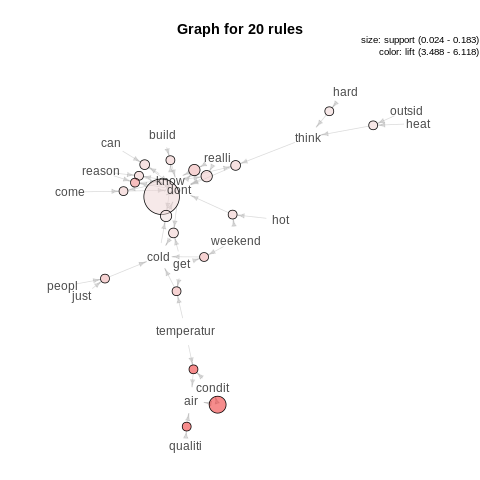

In [0]:
%%R
plot(subrules, method="graph", control=list(type="items"))

In [0]:
%%R
## Support 0.0001 and confidence 0.75 confidence sort
mydata <- sapply(mydata,as.logical)
rules <- apriori(mydata,parameter = list(sup = Support_ARM, conf = Confidence_ARM,target="rules"))
summary(rules)
rules.sorted <- sort(rules, by="confidence")

subrules <- head(sort(rules, by="confidence"),Number_of_rules)
view(subrules)
write(subrules, file = "dataNoClusteringSup00005Conf_confidence.csv", sep = ",")

set.seed(1)


Error in as(data, "transactions") : 
  no method or default for coercing “logical” to “transactions”


/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in as(data, "transactions") : 
  no method or default for coercing “logical” to “transactions”

  warnings.warn(x, RRuntimeWarning)


Available control parameters (with default values):
main	 =  Graph for 20 rules
nodeColors	 =  c("#66CC6680", "#9999CC80")
nodeCol	 =  c("#EE0000FF", "#EE0303FF", "#EE0606FF", "#EE0909FF", "#EE0C0CFF", "#EE0F0FFF", "#EE1212FF", "#EE1515FF", "#EE1818FF", "#EE1B1BFF", "#EE1E1EFF", "#EE2222FF", "#EE2525FF", "#EE2828FF", "#EE2B2BFF", "#EE2E2EFF", "#EE3131FF", "#EE3434FF", "#EE3737FF", "#EE3A3AFF", "#EE3D3DFF", "#EE4040FF", "#EE4444FF", "#EE4747FF", "#EE4A4AFF", "#EE4D4DFF", "#EE5050FF", "#EE5353FF", "#EE5656FF", "#EE5959FF", "#EE5C5CFF", "#EE5F5FFF", "#EE6262FF", "#EE6666FF", "#EE6969FF", "#EE6C6CFF", "#EE6F6FFF", "#EE7272FF", "#EE7575FF",  "#EE7878FF", "#EE7B7BFF", "#EE7E7EFF", "#EE8181FF", "#EE8484FF", "#EE8888FF", "#EE8B8BFF", "#EE8E8EFF", "#EE9191FF", "#EE9494FF", "#EE9797FF", "#EE9999FF", "#EE9B9BFF", "#EE9D9DFF", "#EE9F9FFF", "#EEA0A0FF", "#EEA2A2FF", "#EEA4A4FF", "#EEA5A5FF", "#EEA7A7FF", "#EEA9A9FF", "#EEABABFF", "#EEACACFF", "#EEAEAEFF", "#EEB0B0FF", "#EEB1B1FF", "#EEB3B3FF", "#EE

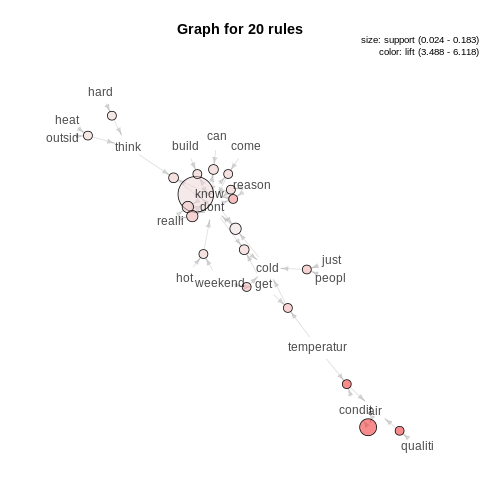

In [0]:
%%R
plot(subrules, method="graph", control=list(type="items"))

# Topic Modelling of Survey Responses

## Read in the Data

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from textblob import TextBlob, Word
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.classifiers import NaiveBayesClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD

In [0]:
survey_resp_temp = pd.read_excel('SLFC survey.xlsx', 
                            sheet_name = 'Temp')
survey_resp_temp = survey_resp_temp[['Floor Work On','Temperature']]
survey_resp_temp = survey_resp_temp.replace('B1 Basement', 'B')
survey_resp_temp[0:5]

,Floor Work On,Temperature
0,3,A proper BAS system that can actually determin...
1,4,I think probably that it's not adjusted to the...
2,7,The heat is not high enough so put on more heat.
3,13,I completed this survey last year and also com...
4,3,I'm thinking it's just the seasons changing. ...


In [0]:
survey_resp_maint = pd.read_excel('SLFC survey.xlsx', 
                            sheet_name = 'Maint')
survey_resp_maint = survey_resp_maint[['Floor Work On','Maintenance']]
survey_resp_maint = survey_resp_maint.replace('B1 Basement', 'B')
survey_resp_maint[0:5]

,Floor Work On,Maintenance
0,3,Just because this building is energy efficient...
1,11,"The bicycle locker room can always be better, ..."
2,13,I think the biggest thing I notice is the ligh...
3,2,"The washrooms on the 2nd floor, the womens was..."
4,13,The mens bathroom on the 13th floor that have ...


Clean up the text (i.e. remove stopwords and make lowercase)

In [0]:
survey_resp_temp['Temperature'] = survey_resp_temp['Temperature'].apply(clean_text)
survey_resp_temp['Temperature'].apply(lambda x: len(x.split(' '))).sum()
survey_resp_temp[0:5]

,Floor Work On,Temperature
0,3,proper bas system actually determine air tempe...
1,4,think probably adjusted changes temperatures s...
2,7,heat high enough put heat
3,13,completed survey last year also complained tem...
4,3,im thinking seasons changing cold cold hot hot...


In [0]:
survey_resp_maint['Maintenance'] = survey_resp_maint['Maintenance'].apply(clean_text)
survey_resp_maint['Maintenance'].apply(lambda x: len(x.split(' '))).sum()
survey_resp_maint[0:5]

,Floor Work On,Maintenance
0,3,building energy efficient doesnt mean type sus...
1,11,bicycle locker room always better bit space se...
2,13,think biggest thing notice lights cant believe...
3,2,washrooms 2nd floor womens washroom especially...
4,13,mens bathroom 13th floor malfunctioning taps s...


## Create the vectorized arrays for the text

In [0]:
#Create a vectorizer (TF-idf and count) for temperature
vectorizer = CountVectorizer()
vectorizer_TFIDF = TfidfVectorizer()
# apply transformation
tf_temp = vectorizer.fit_transform(survey_resp_temp['Temperature']).toarray()
tf_idf_temp = vectorizer_TFIDF.fit_transform(survey_resp_temp['Temperature']).toarray()
# tf_feature_names tells us what word each column in the matric represents
tf_feature_names_temp = vectorizer.get_feature_names()
tf_idf_feature_names_temp = vectorizer_TFIDF.get_feature_names()

In [0]:
#Create a vectorizer (TF-idf and count) for maintenance
tf_maint = vectorizer.fit_transform(survey_resp_maint['Maintenance']).toarray()
tf_idf_maint = vectorizer_TFIDF.fit_transform(survey_resp_maint['Maintenance']).toarray()
# tf_feature_names tells us what word each column in the matric represents
tf_feature_names_maint = vectorizer.get_feature_names()
tf_idf_feature_names_maint = vectorizer_TFIDF.get_feature_names()

## Create a function to turn the model object "model" into a dataframe that shows the created topics

In [0]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

## Topic modelling using the LDA (Latent Dirichlet Allocation) algorithm

In [0]:
#%% Topic modelling using LDA (Latent Dirichlet Allocation) for Thermal complaints
# Create the model object. Start by choosing 10 topics
number_of_topics = 6
# Create the LDA (Latent Dirichlet Allocation ) model 
model_LDA_temp = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model_LDA_temp.fit(tf_idf_temp)
no_top_words = 10
Topics_LDA_temp = display_topics(model_LDA_temp, tf_feature_names_temp, no_top_words)    
Topics_LDA_temp

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights
0,think,2.0,know,6.5,sure,3.7,think,1.6,turn,5.4,control,3.6
1,air,1.5,dont,6.0,im,3.3,office,1.6,heat,4.7,air,3.2
2,probably,1.5,air,2.6,really,3.0,yet,1.5,cold,4.0,temperature,2.9
3,circulation,1.5,heating,2.3,dont,2.8,window,1.4,idea,4.0,floor,2.8
4,better,1.1,conditioning,2.2,know,2.8,sure,1.3,think,3.9,would,2.7
5,consideration,1.1,say,1.9,cold,2.4,really,1.3,ac,3.4,dont,2.7
6,cold,1.0,thermostat,1.9,temperature,2.4,freezing,1.2,day,1.8,know,2.6
7,ac,1.0,get,1.9,building,1.7,okay,1.2,fix,1.7,turn,2.3
8,colder,1.0,good,1.8,control,1.5,system,1.2,temperature,1.7,better,2.3
9,change,0.9,temperature,1.8,make,1.4,earlier,1.1,time,1.7,reason,2.3


In [0]:
#export_csv = Topics_LDA_temp.to_csv ('LDA_Temp.csv', index = None, header=True)

In [0]:
#Find the topics for each temperature survey response
Survey_Classification_LDA_temp = pd.DataFrame(model_LDA_temp.transform(tf_idf_temp))
Survey_Classification_LDA_temp['Survey response no.'] = np.arange(1,len(survey_resp_temp)+1,1)
Survey_Classification_LDA_temp = Survey_Classification_LDA_temp[['Survey response no.', 0, 1, 2, 3, 4, 5]]
Survey_Classification_LDA_temp [0:5]

,Survey response no.,0,1,2,3,4,5
0,1,0.031568,0.031679,0.031755,0.031700,0.031535,0.841762
1,2,0.031353,0.031649,0.033209,0.031586,0.840630,0.031574
2,3,0.056092,0.056434,0.056671,0.056115,0.718145,0.056542
3,4,0.024940,0.874559,0.025273,0.025081,0.025026,0.025121
4,5,0.037249,0.037550,0.037841,0.037236,0.812348,0.037775


In [0]:
#%% Topic modelling using LDA (Latent Dirichlet Allocation) for Maintenance complaints
# Create the model object. Start by choosing 10 topics
number_of_topics = 6
# Create the LDA (Latent Dirichlet Allocation ) model 
model_LDA_maint = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model_LDA_maint.fit(tf_idf_maint)
no_top_words = 5
Topics_LDA_maint = display_topics(model_LDA_maint, tf_feature_names_maint, no_top_words)    
export_csv = Topics_LDA_maint.to_csv ('LDA_Maint.csv', index = None, header=True)
Topics_LDA_maint

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights
0,elevators,4.1,people,2.3,building,2.7,paper,2.2,soap,3.3,often,1.7
1,floor,3.2,stuck,1.6,could,2.5,cant,2.1,would,3.0,would,1.7
2,slow,2.9,cleaners,1.6,cold,2.3,washrooms,1.9,like,2.9,floor,1.7
3,need,2.3,clean,1.5,would,2.3,people,1.8,floor,2.9,work,1.5
4,one,2.2,elevators,1.4,revolving,2.1,floors,1.5,elevators,2.5,time,1.4


QUICK NOTE Clearly the LDA algorithm doesn't work very well against short sentences less that 140 characters (aka tweets) For example, the word global warming comes up in almost every topic so maybe it should be added to the stopwords list Let's try an alternate model (NMF) in order to see if the outcome improves versus LDA

## Topic modelling using the NMF (Non-negative Matrix Factorization) algorithm

In [0]:
#%% Topic modelling using NMF (Non-negative Matrix Factorization) for thermal complaints
number_of_topics = 6
model_NMF_temp = NMF(n_components=number_of_topics, random_state=0, alpha=.01, l1_ratio=.9)
model_NMF_temp.fit(tf_idf_temp)
#apply this function to the model
no_top_words = 10
Topics_NMF_temp = display_topics(model_NMF_temp, tf_feature_names_temp, no_top_words) 
export_csv = Topics_NMF_temp.to_csv ('NMF_Temp.csv', index = None, header=True)   
Topics_NMF_temp

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights
0,know,1.7,turn,1.5,cold,1.3,think,0.6,air,1.1,sure,1.1
1,dont,1.5,heat,1.2,ac,0.3,temperature,0.6,conditioning,0.8,im,0.8
2,really,0.4,ac,0.5,make,0.2,control,0.5,circulation,0.4,rectify,0.1
3,reason,0.2,sooner,0.2,warm,0.2,building,0.4,needs,0.3,difficult,0.1
4,idea,0.2,fall,0.2,really,0.2,would,0.3,summer,0.2,reason,0.1
5,say,0.1,think,0.1,get,0.2,office,0.3,increase,0.2,honest,0.1
6,problem,0.1,allow,0.1,hot,0.2,floor,0.2,better,0.2,operates,0.1
7,question,0.1,yet,0.1,winter,0.2,thermostats,0.2,good,0.2,maybe,0.1
8,anything,0.1,turned,0.1,sometimes,0.2,outside,0.2,turned,0.1,check,0.1
9,good,0.1,bit,0.1,warmer,0.1,could,0.2,less,0.1,regularly,0.1


In [0]:
#Find the topics for each thermal survey response
Survey_Classification_NMF_temp = pd.DataFrame(model_NMF_temp.transform(tf_idf_temp))
Survey_Classification_NMF_temp['Survey response no.'] = np.arange(1,len(survey_resp_temp)+1,1)
Survey_Classification_NMF_temp = Survey_Classification_NMF_temp[['Survey response no.', 0, 1, 2, 3, 4, 5]]
Survey_Classification_NMF_temp[0:5]

,Survey response no.,0,1,2,3,4,5
0,1,0.0,0.000000,0.009180,0.092335,0.173449,0.044649
1,2,0.0,0.000000,0.000000,0.131085,0.000000,0.174318
2,3,0.0,0.199607,0.000000,0.000195,0.016081,0.000000
3,4,0.0,0.000000,0.082839,0.139084,0.015157,0.030467
4,5,0.0,0.000000,0.218285,0.060488,0.000000,0.067027


In [0]:
#%% Topic modelling using NMF (Non-negative Matrix Factorization) for maintenance complaints
number_of_topics = 6
model_NMF_maint = NMF(n_components=number_of_topics, random_state=0, alpha=.01, l1_ratio=.9)
model_NMF_maint.fit(tf_idf_maint)
#apply this function to the model
no_top_words = 10
Topics_NMF_maint = display_topics(model_NMF_maint, tf_feature_names_maint, no_top_words)  
export_csv = Topics_NMF_maint.to_csv ('NMF_Maint.csv', index = None, header=True)   
Topics_NMF_maint

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights
0,floor,0.7,elevators,1.2,going,0.7,stairs,0.7,cold,0.8,would,0.8
1,soap,0.4,slow,0.9,people,0.3,cant,0.6,water,0.7,nice,0.5
2,bathrooms,0.4,stuck,0.2,building,0.3,use,0.6,sometimes,0.2,food,0.4
3,often,0.4,get,0.2,im,0.3,go,0.5,temperature,0.2,like,0.3
4,washrooms,0.3,people,0.2,lrt,0.3,floors,0.3,always,0.2,building,0.2
5,need,0.3,door,0.1,know,0.2,take,0.3,summer,0.2,buy,0.2
6,clean,0.3,doors,0.1,dont,0.2,elevator,0.2,hot,0.2,say,0.2
7,bathroom,0.3,little,0.1,construction,0.2,swipe,0.2,pretty,0.1,renovations,0.2
8,washroom,0.2,time,0.1,long,0.2,locked,0.2,find,0.1,choices,0.1
9,enough,0.2,come,0.1,parking,0.2,walk,0.2,get,0.1,helpful,0.1


In [0]:
#Find the topics for each survey response
Survey_Classification_NMF_maint = pd.DataFrame(model_NMF_maint.transform(tf_idf_maint))
Survey_Classification_NMF_maint['Survey response no.'] = np.arange(1,len(survey_resp_maint)+1,1)
Survey_Classification_NMF_maint = Survey_Classification_NMF_maint[['Survey response no.', 0, 1, 2, 3, 4, 5]]
Survey_Classification_NMF_maint[0:5]

,Survey response no.,0,1,2,3,4,5
0,1,0.000000,0.00000,0.157118,0.000000,0.000000,0.007499
1,2,0.020163,0.00491,0.001976,0.000000,0.037001,0.038464
2,3,0.000000,0.00000,0.156019,0.031922,0.016838,0.012033
3,4,0.171878,0.00000,0.000000,0.000000,0.059314,0.000683
4,5,0.267989,0.00000,0.000000,0.014281,0.001633,0.000000
